### lvPPA tau-PET: Exploratory Analysis

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
import pandas as pd
from sklearn.linear_model import LinearRegression

The main spreadsheet is found in Box: lvppa_tau-PET images/FINAL_COHORT/lvPPA_typicalAD_tau-PET_n27_MM_ALdemo_050622

From the main spreadsheet, there are sub-sheets:
1. lvppa_ordered_freesurfer.csv
2. ad_ordered_freesurfer.csv
3. lvppa_ordered_tau.csv
4. ad_ordered_tau.csv

These sub-sheets contain the data (ordered by lobe) & contain covariates.


## lvPPA & AD residual thickness correlation

In [35]:
#Data Import
lvppa_data = pd.read_csv('/Users/jpillai/lvppa_pet/lvppa_covar_freesurfer.csv')
ad_data = pd.read_csv('/Users/jpillai/lvppa_pet/ad_covar_freesurfer.csv')

In [27]:
#Model Function
columns_to_skip = ['Age at TAU', 'Sex', 'Global CT']

def residuals_model(data1, data2, skip):
    model1 = LinearRegression()
    model2 = LinearRegression()
    X1 = data1[columns_to_skip]
    X2 = data2[columns_to_skip]
    n_parcels = data1.shape[1]
    residuals1 = pd.DataFrame(index=data1.index, columns=data1.columns[4:n_parcels])
    residuals2 = pd.DataFrame(index=data2.index, columns=data2.columns[4:n_parcels])
    
    for i in range(skip, n_parcels):
        y1 = data1.iloc[:, i]
        y2 = data2.iloc[:, i]
        model1.fit(X1, y1)
        model2.fit(X2, y2)
        residuals1.iloc[:, i-skip] = y1 - model1.predict(X1)
        residuals2.iloc[:, i-skip] = y2 - model2.predict(X2)
        
    return model1.intercept_, model1.coef_, model2.intercept_, model2.coef_, residuas

In [39]:
#Fit a multiple regression for lvppa & AD thickness
from sklearn.linear_model import LinearRegression

# create linear regression object
mlr_1 = LinearRegression()
mlr_2 =  LinearRegression()

# fit linear regression

X1 = lvppa_data[['Age at TAU', 'Sex', 'Global CT']]
X2 = ad_data[['Age at TAU', 'Sex', 'Global CT']]

skip = 4 # the number of columns to skip
n_parcels = lvppa_data.shape[1]

residuals_lvppa = pd.DataFrame(index=lvppa_data.index, columns=lvppa_data.columns[4:n_parcels])
residuals_ad = pd.DataFrame(index=ad_data.index, columns=ad_data.columns[4:n_parcels])

for i in range(skip, n_parcels):
    y_1 = lvppa_data.iloc[:, i]
    y_2 = ad_data.iloc[:, i]
    mlr_1.fit(X1, y_1)
    mlr_2.fit(X2, y_2)
    residuals_lvppa.iloc[:, i-skip] = y_1 - mlr_1.predict(X1)
    residuals_ad.iloc[:, i-skip] = y_2 - mlr_2.predict(X2)

#lvPPA
print('lvPPA thickness:', mlr_1.intercept_, mlr_1.coef_)

#AD
print('AD thickness:', mlr_2.intercept_, mlr_2.coef_)


lvPPA thickness: 1.5866091625828607 [-0.00517097 -0.02773218  0.16564654]
AD thickness: 1.3911711732395036 [-0.00061493 -0.02772876  0.08035356]


In [42]:
# Compute the correlations: Using the residuals from the regression model, you can compute the pairwise correlations 
# between each parcel, as described in the previous answer. This results in a 64 by 64 matrix, 
# where each element represents the partial correlation between two parcels, controlling 
# for the effects of age, sex, and global thickness??.

In [ ]:
#RESIDUAL CORRELATION

#residuals_lvppa
lvppa_corr = residuals_lvppa.corr()

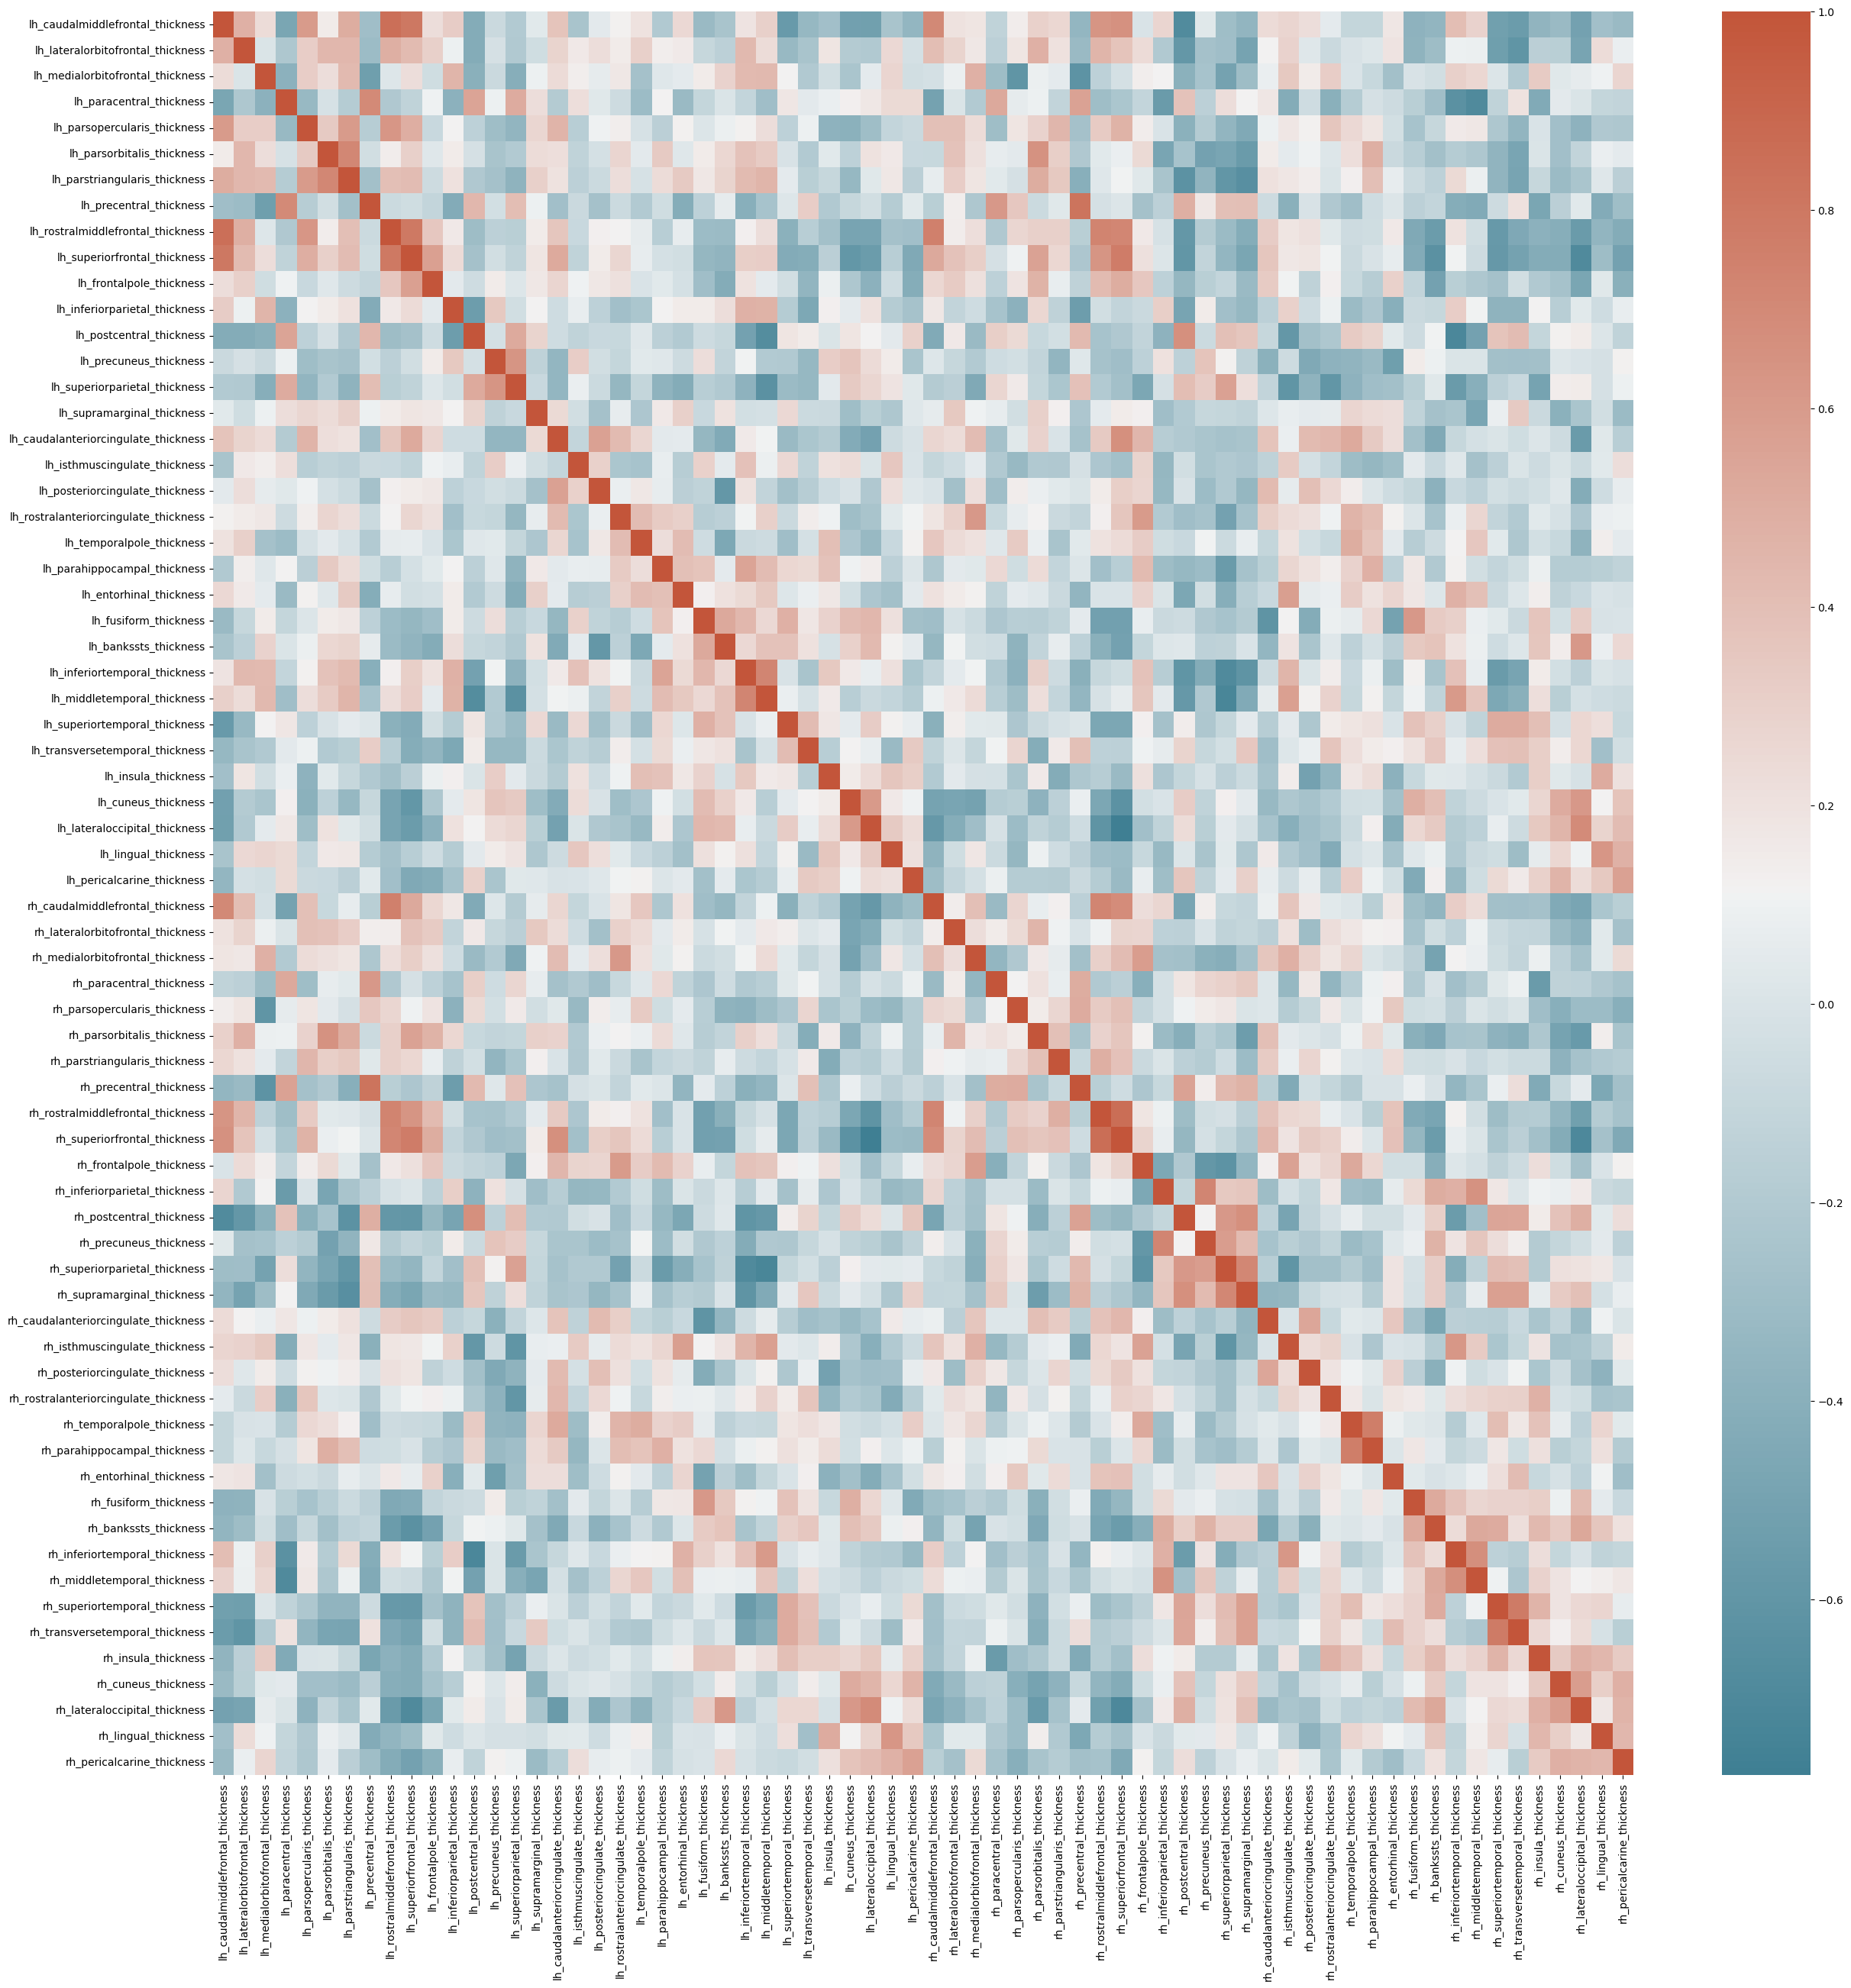

In [44]:
plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220, 20, as_cmap=True) #lighter red to blue
#cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(lvppa_corr, cmap=cmap)
plt.savefig('lvPPA_thickness.png', dpi=400)

In [ ]:
#residuals_ad
ad_corr = residuals_ad.corr()
ad_corr

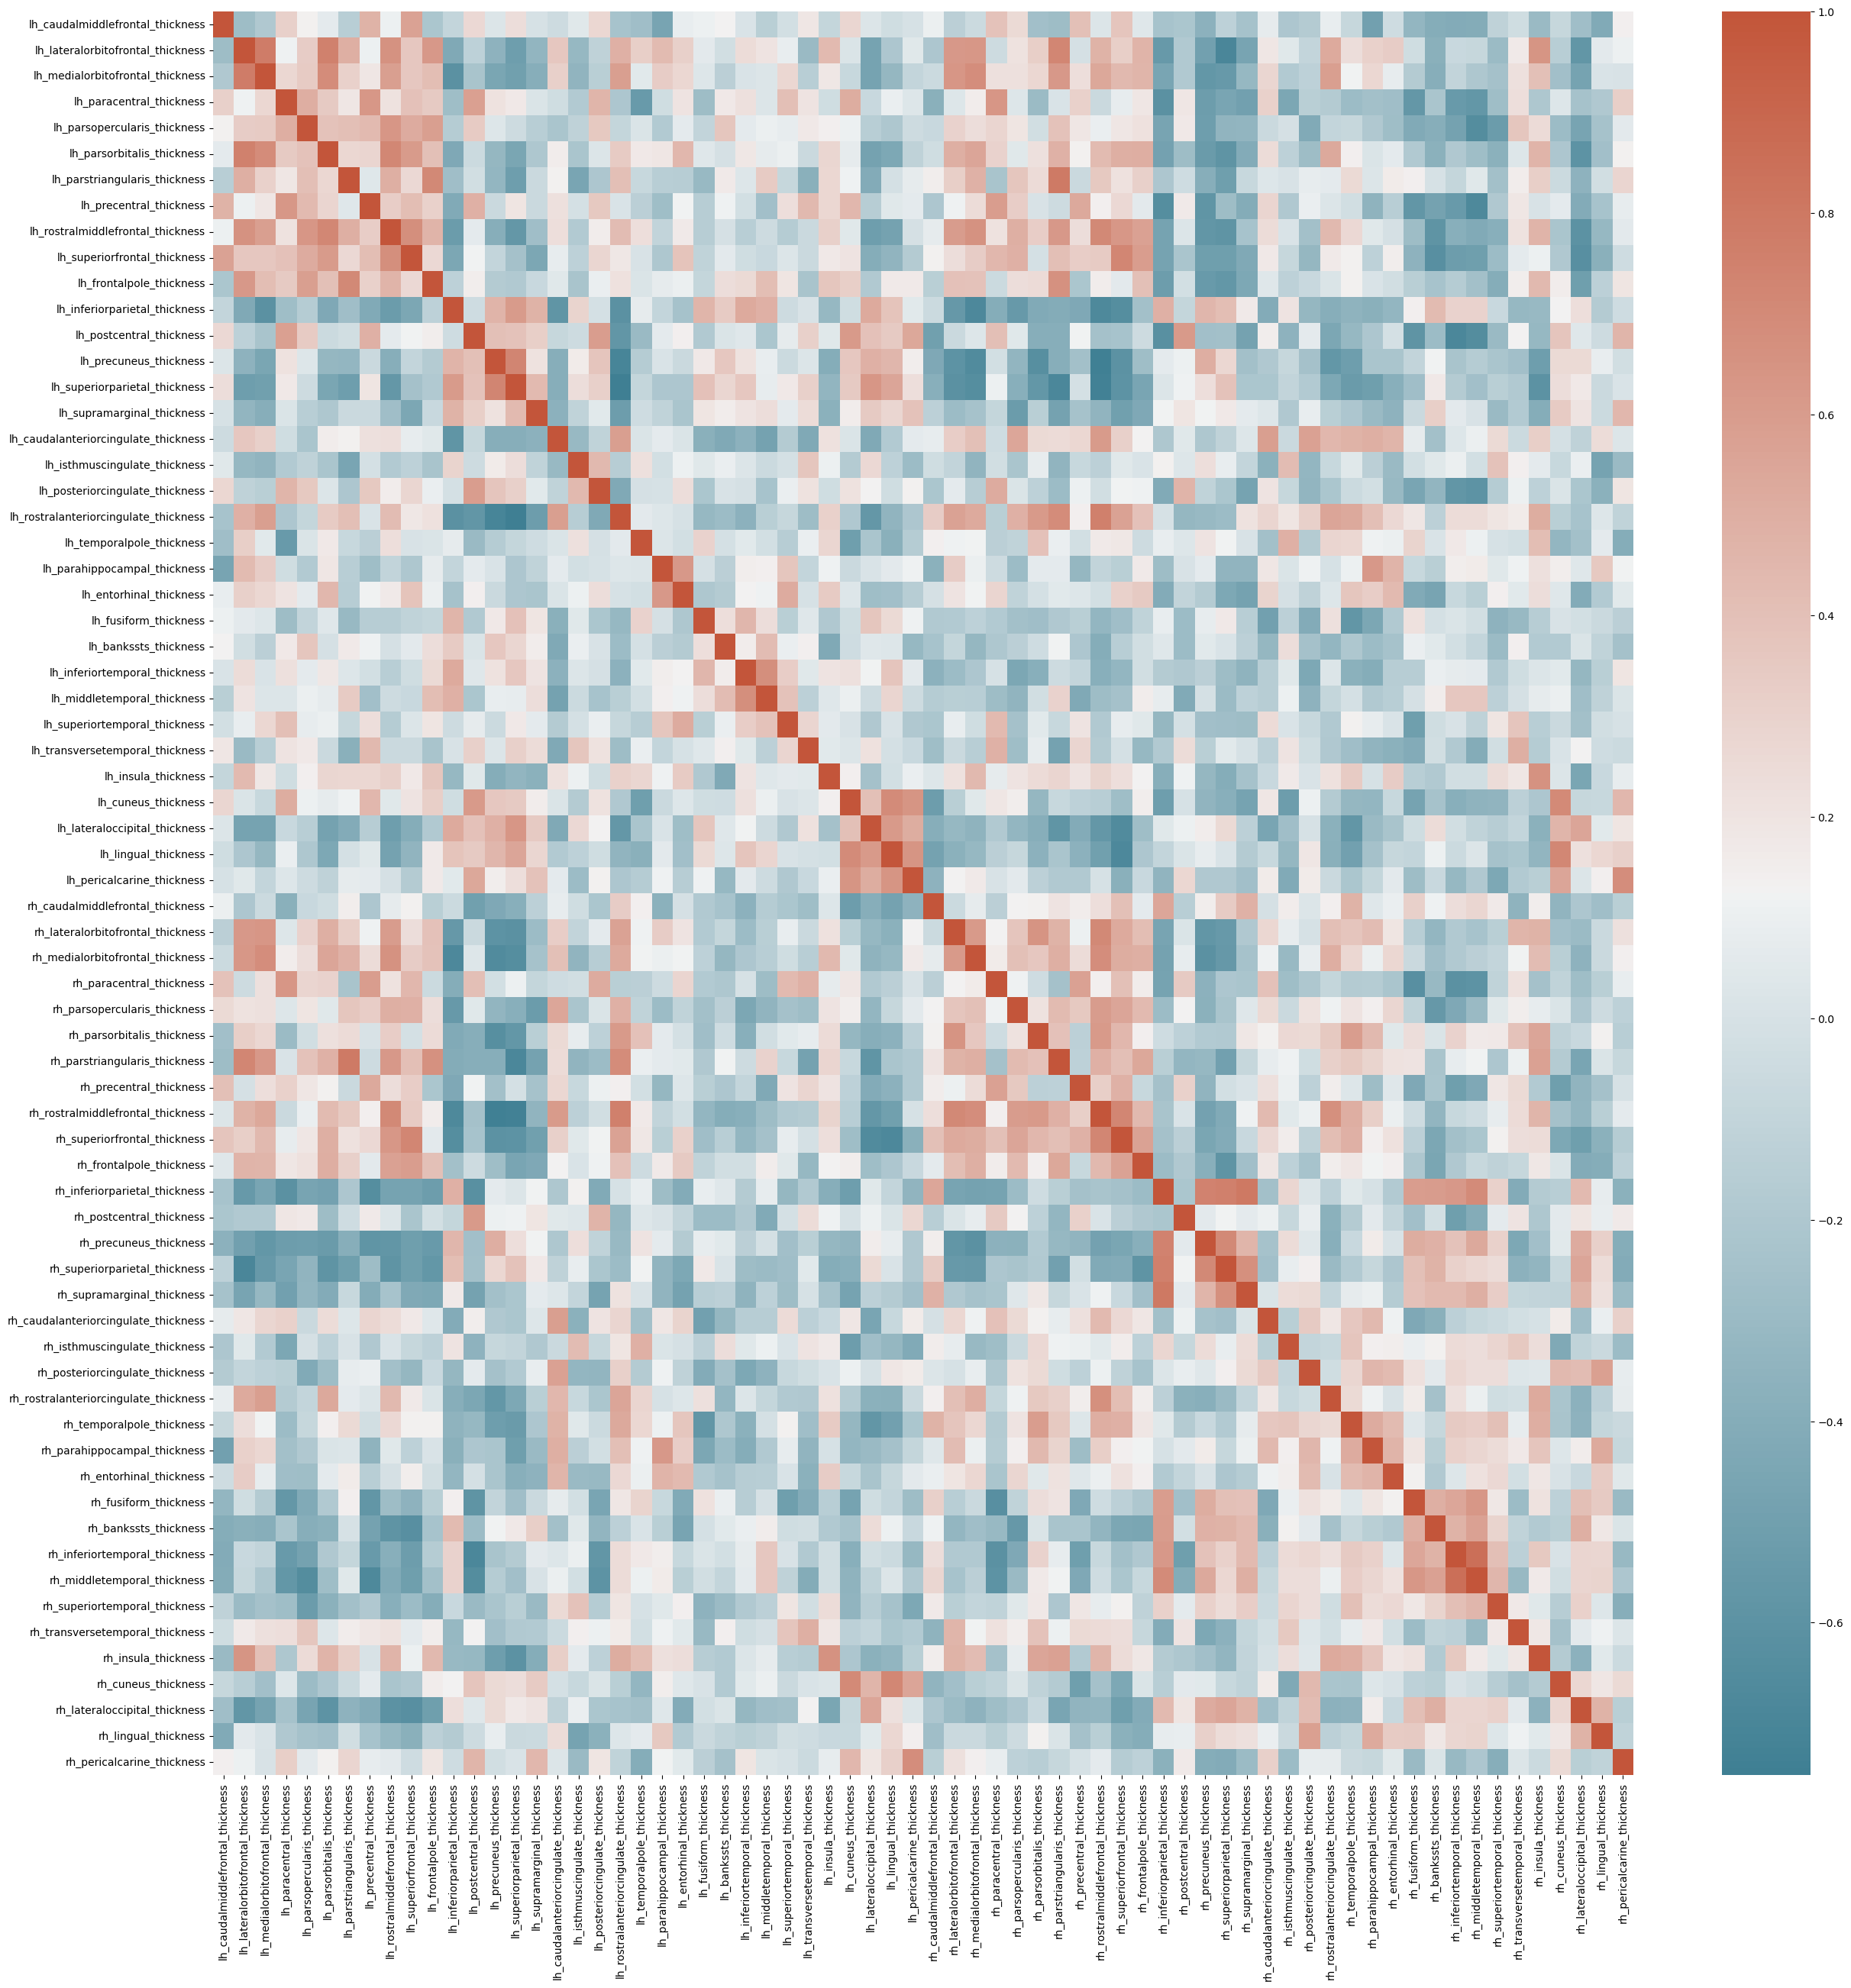

In [46]:
plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220, 20, as_cmap=True) #lighter red to blue
#cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(ad_corr, cmap=cmap)
plt.savefig('AD_thickness.png', dpi=400)

In [84]:
#------Functions (ONLY IF WE WANT TO P-VALUE MASK!!)-------


#P-values masking (0.001, 0.01, 0.05)
#0.01
#lvppa_correl_.loc[(lvppa_correl_['P Value'] > 0.01, 'Correlation (R)')] = 0


#correlation and P-value
def get_corr_p(df_1, df_2):
    feat1 = []
    feat2 = []
    corrs = []
    p_values = []

    for i in df_1.columns:
        for j in df_2.columns:
            #print(i,j)
            corr, p_value = scipy.stats.pearsonr(df_1[i], df_2[j])
            feat1.append(i)
            feat2.append(j)
            corrs.append(corr)
            p_values.append(p_value)
            

    correl = {'Feature 1': feat1, 'Feature 2': feat2, 'Correlation (R)': corrs, 'P Value': p_values}
    correl_df = pd.DataFrame(data=correl)
    return correl_df

#feature list
def features(correlation):
    feature_list = (correlation.columns).to_list()
    return feature_list

#create empty df
def pivoted_df(correlation):
    subset = correlation.head(68)
    pivoted_df = subset.pivot(columns = 'Feature 2', values = 'Correlation (R)').dropna()
    pivoted_df = pivoted_df.reindex(feature_list, axis = 1)
    return pivoted_df 

#final correlation df 
def final_corr_df(correlation, pivoted_df):
    for i in feature_list:
        df = correlation[correlation['Feature 1'].str.contains(i)]
        df = df.set_index(df['Feature 1'])
        df = df.iloc[:, 1:]
        new_df = df.pivot(columns = 'Feature 2', values = 'Correlation (R)')
        new_df = new_df.reindex(feature_list, axis=1)
        pivoted_df = pivoted_df.append(new_df)
    return pivoted_df

#heatmap
def heatmap(final_df):
    plt.subplots(figsize=(30,30))
    sns.heatmap(final_df, cmap='Spectral')
    
#EXAMPLE CALL:
    #lvppa_df_1 = lvppa_data
    #lvppa_df_2 = lvppa_data
    #lvppa_correl_ = get_corr_p(lvppa_df_1, lvppa_df_2)
    #feature_list = features(lvppa_corr)
    #pivoted_lvppa_df = pivoted_df(lvppa_correl_)
    #final_lvppa_df = final_corr_df(lvppa_correl_, pivoted_lvppa_df)
    #final_lvppa_df

### lvPPA & AD residual tau correlation

In [47]:
#Data Import
lvppa_data_tau = pd.read_csv('/Users/jpillai/lvppa_pet/lvppa_covar_freesurfer_tau.csv')
ad_data_tau = pd.read_csv('/Users/jpillai/lvppa_pet/ad_covar_freesurfer_tau.csv')
lvppa_data_tau.head()

,PIDN,Age at TAU,Sex,Global CT,ctx_lh_caudalmiddlefrontal,ctx_lh_lateralorbitofrontal,ctx_lh_medialorbitofrontal,ctx_lh_paracentral,ctx_lh_parsopercularis,ctx_lh_parsorbitalis,...,ctx_rh_bankssts,ctx_rh_inferiortemporal,ctx_rh_middletemporal,ctx_rh_superiortemporal,ctx_rh_transversetemporal,ctx_rh_insula,ctx_rh_cuneus,ctx_rh_lateraloccipital,ctx_rh_lingual,ctx_rh_pericalcarine
0,14392,74.40,1,2.028720,2.148065,1.552520,1.417048,1.449800,1.677031,1.593287,...,2.488971,2.567914,2.427385,1.884233,1.272279,1.482145,1.522401,1.854871,1.530378,1.525060
1,14788,59.96,2,2.231885,1.744400,1.494118,1.160675,2.593874,2.092925,1.547209,...,3.531430,2.012885,2.081944,1.895483,2.333589,1.555101,1.959658,2.186352,1.591362,1.375001
2,16304,60.27,2,2.086895,3.334006,2.014825,1.654649,2.284140,2.738462,2.185238,...,2.961100,3.199441,3.032747,2.100075,1.795675,1.855377,1.340482,1.508773,1.330916,1.349684
3,16978,53.20,2,2.064630,1.444305,1.331499,1.121083,1.177403,1.583858,1.471731,...,2.694104,2.618327,2.533329,2.203778,1.965708,1.374094,1.863836,2.378974,1.692071,1.242898
4,17664,63.09,2,2.278725,2.464860,2.212315,1.864080,1.094214,2.315012,2.290100,...,2.866053,2.672072,2.825476,1.912302,1.115523,1.374534,1.778265,2.251078,1.841533,1.383966


In [48]:
#Fit a multiple regression for lvppa & AD tau-pet Freesurfer measures
from sklearn.linear_model import LinearRegression

# create linear regression object
mlr_3 = LinearRegression()
mlr_4 =  LinearRegression()

# fit linear regression

X3 = lvppa_data_tau[['Age at TAU', 'Sex', 'Global CT']]
X4 = ad_data_tau[['Age at TAU', 'Sex', 'Global CT']]

skip = 4 # the number of columns to skip
n_parcels = lvppa_data_tau.shape[1]

residuals_lvppa_tau = pd.DataFrame(index=lvppa_data_tau.index, columns=lvppa_data_tau.columns[4:n_parcels])
residuals_ad_tau = pd.DataFrame(index=ad_data_tau.index, columns=ad_data_tau.columns[4:n_parcels])

for i in range(skip, n_parcels):
    y_3 = lvppa_data_tau.iloc[:, i]
    y_4 = ad_data_tau.iloc[:, i]
    mlr_3.fit(X3, y_3)
    mlr_4.fit(X4, y_4)
    residuals_lvppa_tau.iloc[:, i-skip] = y_3 - mlr_3.predict(X3)
    residuals_ad_tau.iloc[:, i-skip] = y_4 - mlr_4.predict(X4)

#lvPPA
print('lvPPA tau:', mlr_3.intercept_, mlr_3.coef_)

#AD
print('AD tau:', mlr_4.intercept_, mlr_4.coef_)

lvPPA tau: 1.2356628544132993 [-0.00729546  0.0686318   0.16185393]
AD tau: 3.17922608244454 [-0.0120872   0.24327934 -0.6162457 ]


In [49]:
lvppa_tau_corr = residuals_lvppa_tau.corr()

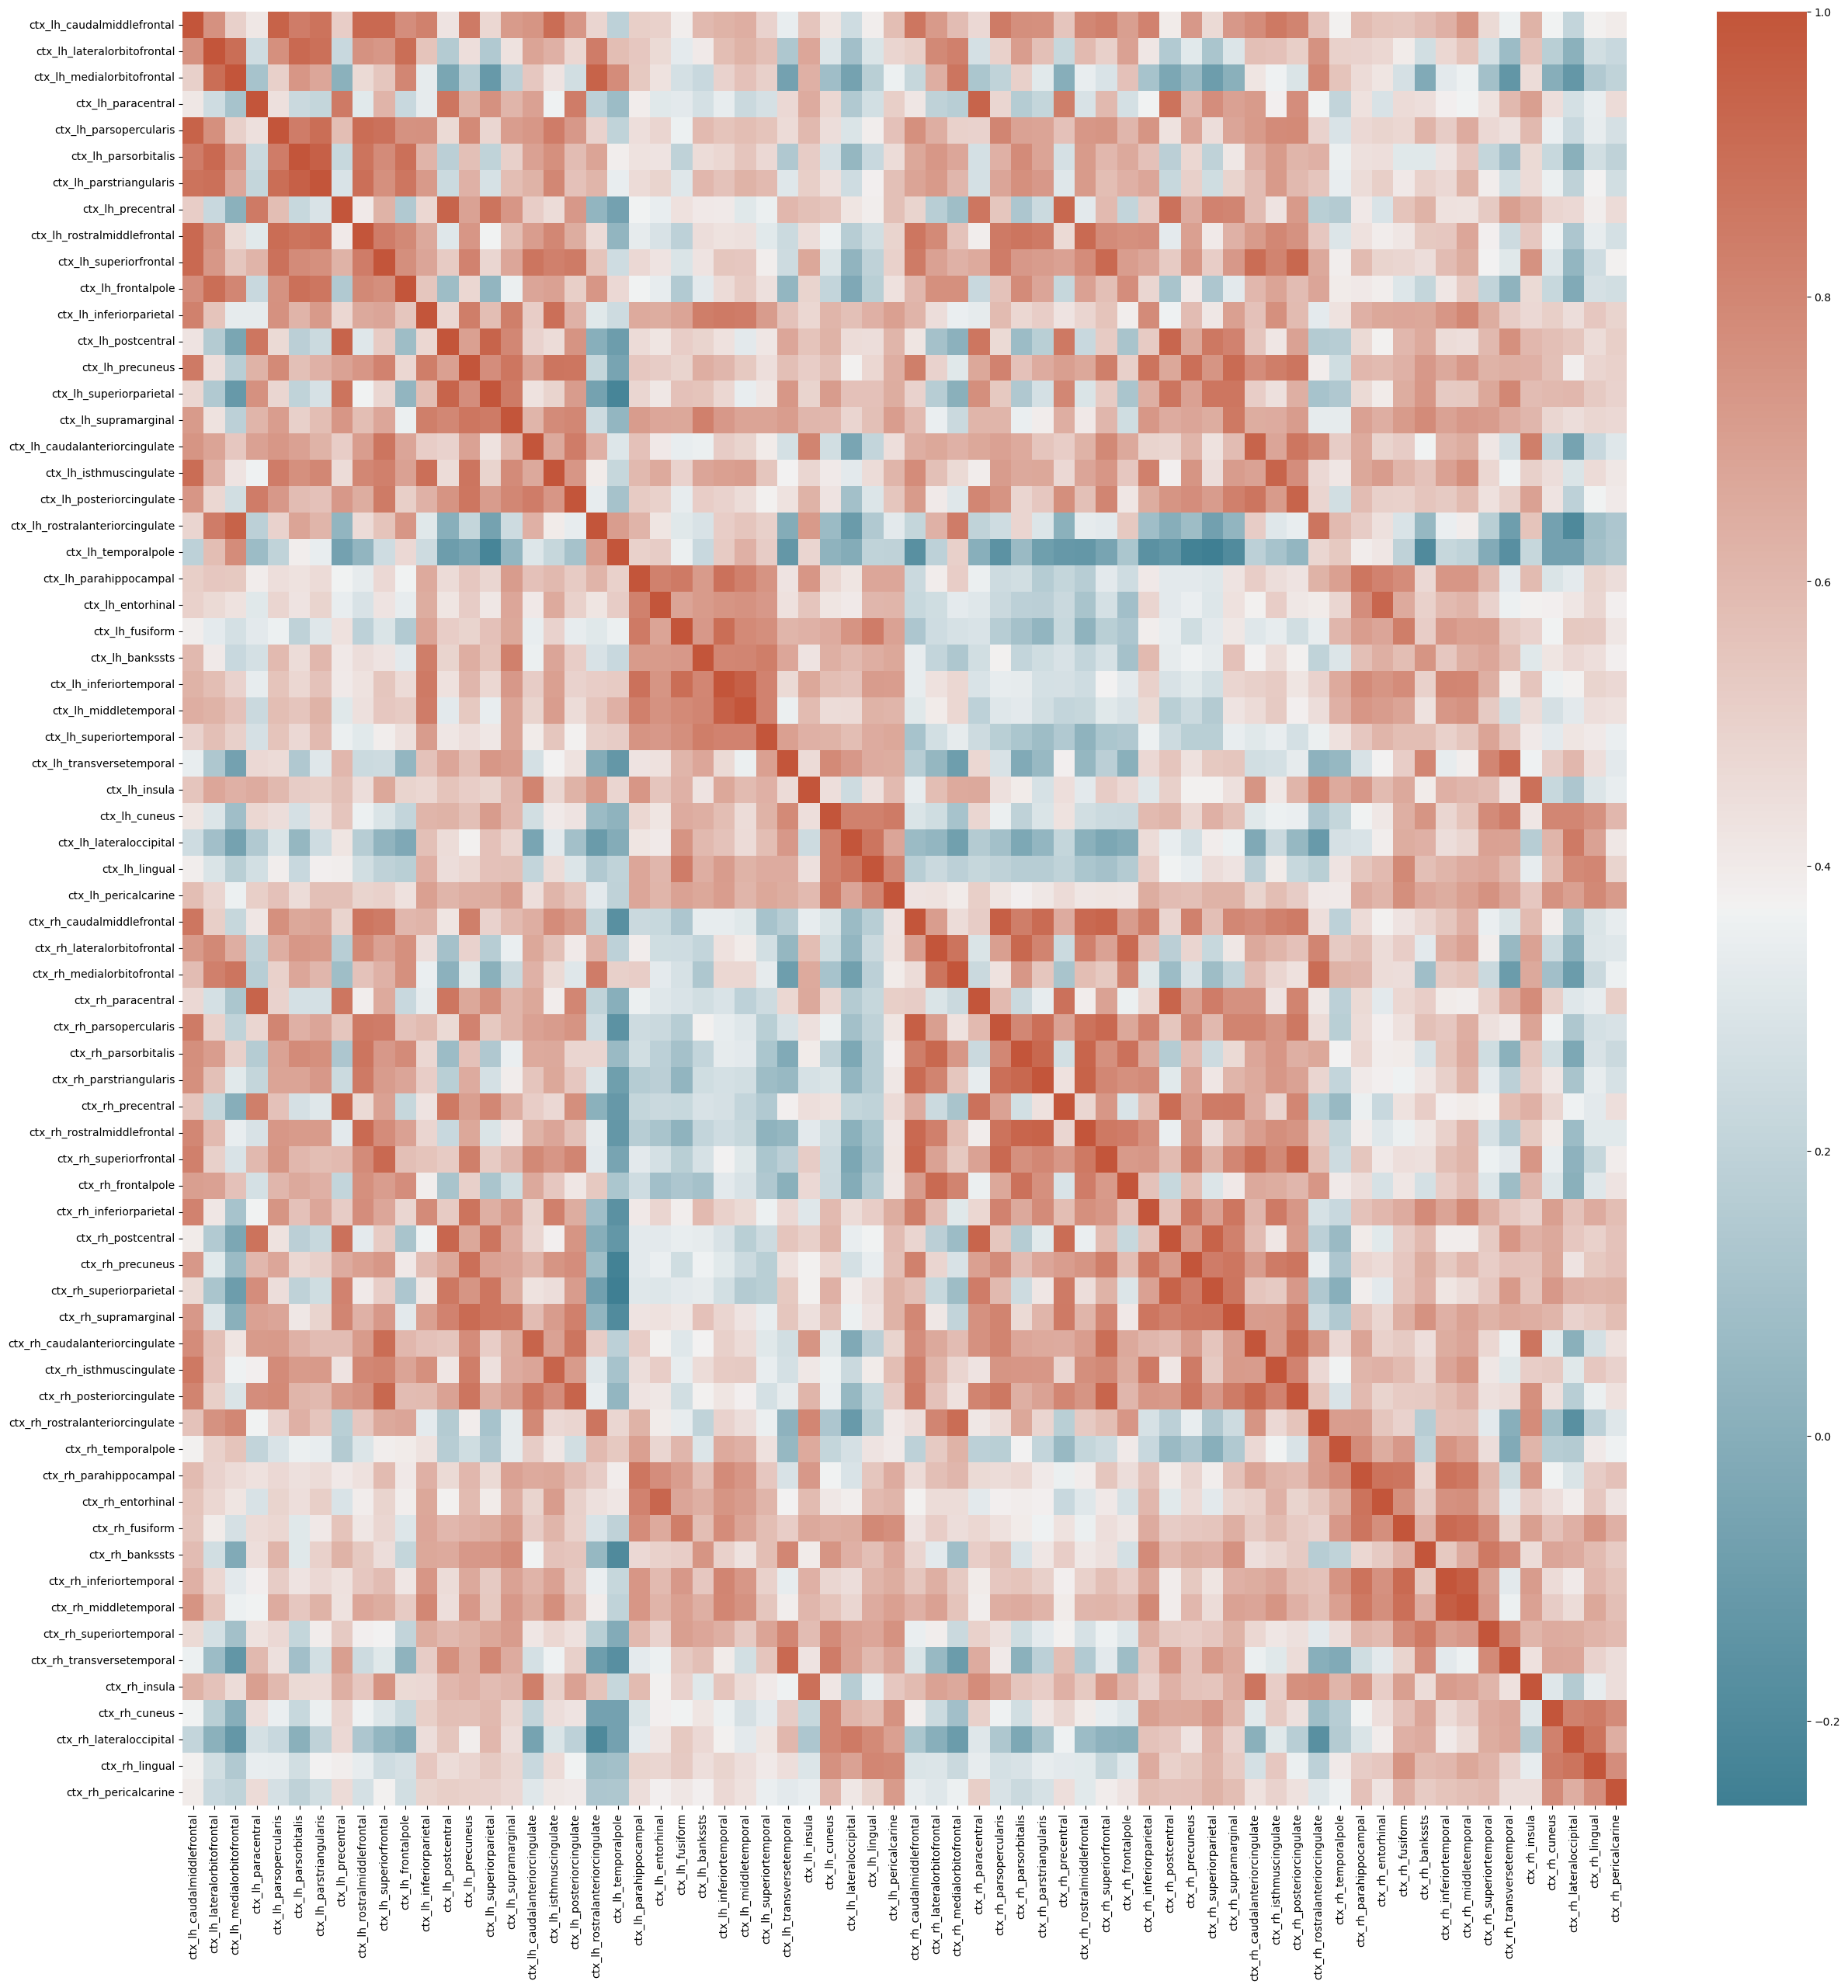

In [50]:
plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220, 20, as_cmap=True) #lighter red to blue
#cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(lvppa_tau_corr, cmap=cmap)
plt.savefig('lvPPA_tau.png', dpi=400)

In [51]:
ad_tau_corr= residuals_ad_tau.corr()

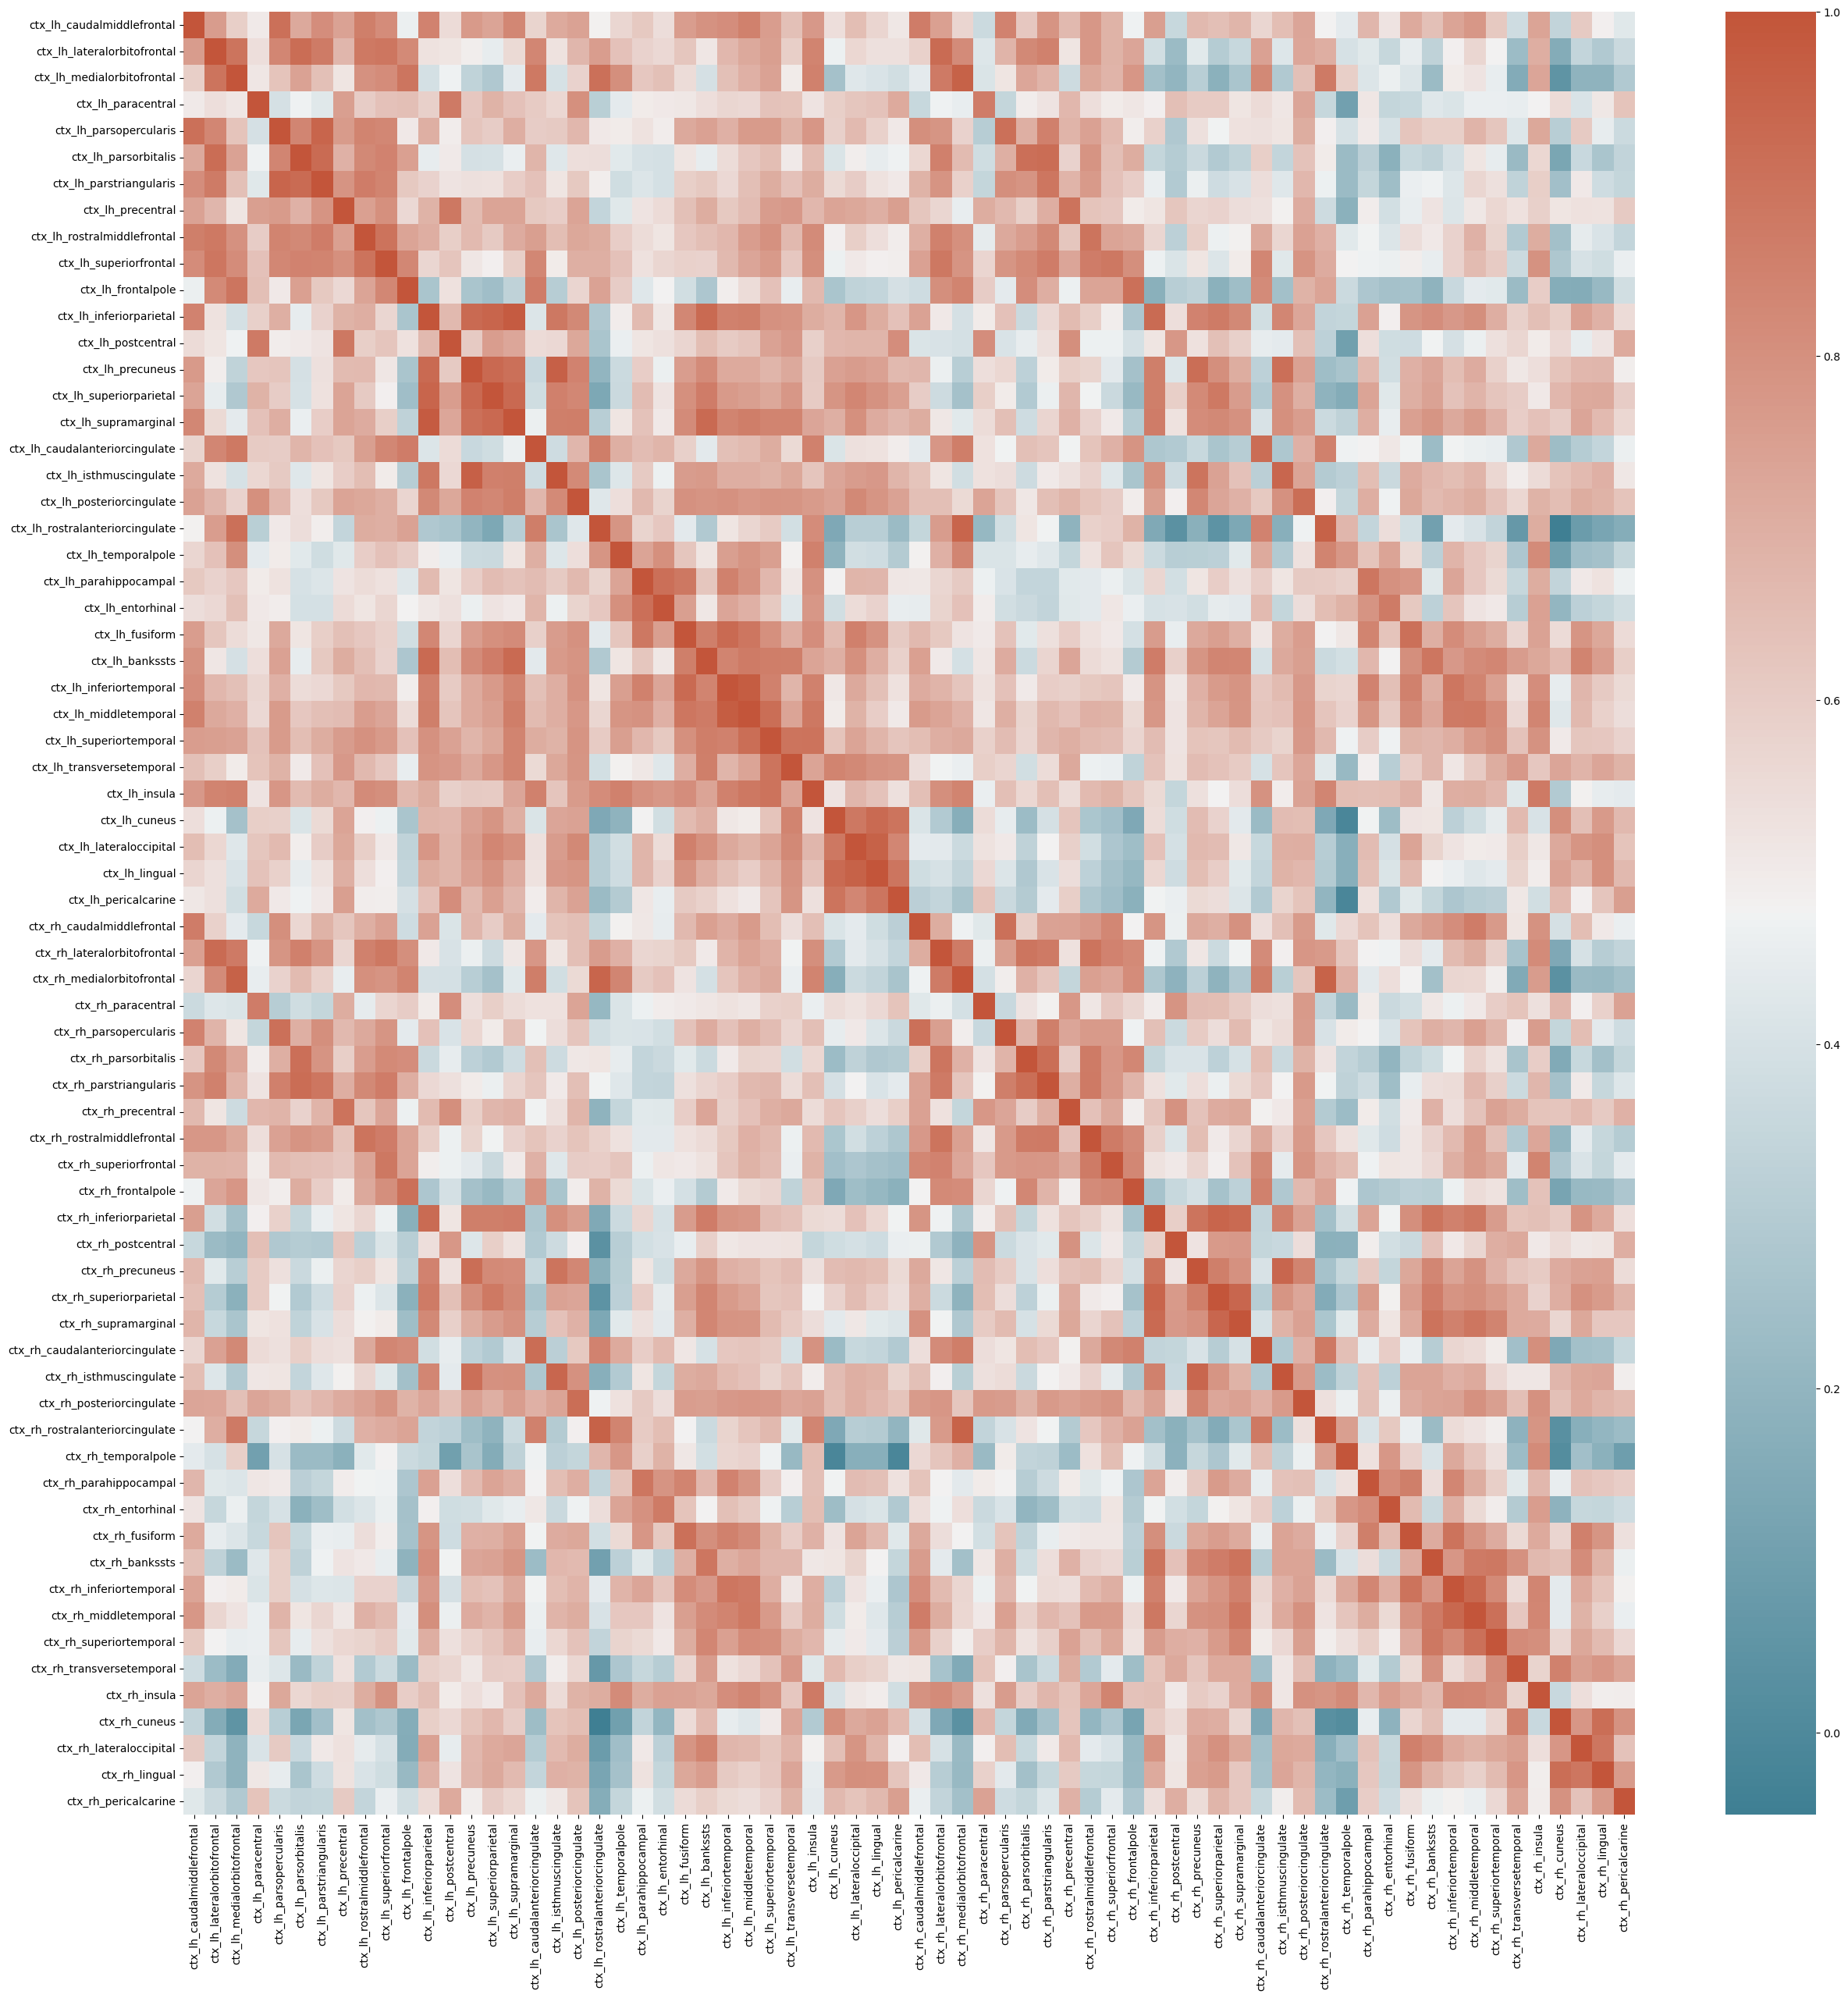

In [52]:
plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(220, 20, as_cmap=True) #lighter red to blue
#cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(ad_tau_corr, cmap=cmap)
plt.savefig('AD_tau.png', dpi=400)